# Data Exploration Analysis

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline

## Data Cleaning

In [3]:
csv_path = r"C:\Users\dhars\Downloads\hotel_bookings.csv"
df = pd.read_csv(csv_path)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [21]:
# Remove duplicate rows
df = df.drop_duplicates()

 # Drop 'agent' and 'company' columns
df = df.drop(columns=['agent', 'company'])

# Drop rows where market_segment is 'Undefined'
df = df[df['market_segment'] != 'Undefined']

In [22]:
# Create datetime column
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)

# Derived features
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_guests'] = df['adults'] + df['children'].fillna(0) + df['babies']

## Data Summary

In [23]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87394 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           87394 non-null  object        
 1   is_canceled                     87394 non-null  int64         
 2   lead_time                       87394 non-null  int64         
 3   arrival_date_year               87394 non-null  int64         
 4   arrival_date_month              87394 non-null  object        
 5   arrival_date_week_number        87394 non-null  int64         
 6   arrival_date_day_of_month       87394 non-null  int64         
 7   stays_in_weekend_nights         87394 non-null  int64         
 8   stays_in_week_nights            87394 non-null  int64         
 9   adults                          87394 non-null  int64         
 10  children                        87392 non-null  float64       
 11  b

## Cancellation Rate By Hotel Type

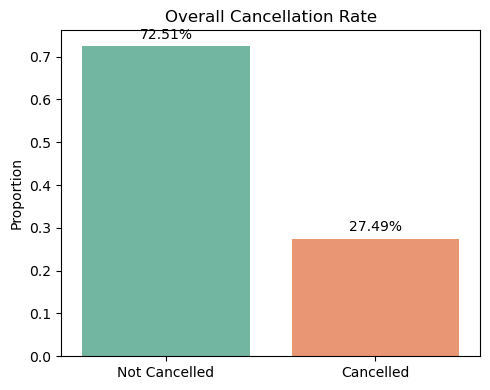

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate cancellation rate
cancel_rate = df['is_canceled'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(5, 4))
ax = sns.barplot(x=cancel_rate.index, y=cancel_rate.values, palette='Set2')

# Title and axis labels
plt.title('Overall Cancellation Rate')
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled'])
plt.ylabel('Proportion')

# Add percentage labels on bars
for i, value in enumerate(cancel_rate.values):
    plt.text(i, value + 0.01, f'{value*100:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The overall cancellation rate in the dataset is 27.49%, meaning just about 1/4 of all bookings were canceled. In contrast, 72.51% of bookings were completed as planned. This high cancellation proportion highlights the importance of understanding the factors driving cancellations, as they represent a significant portion of the hotel's booking behavior and potential revenue loss.

## Hotel Type vs Cancellation

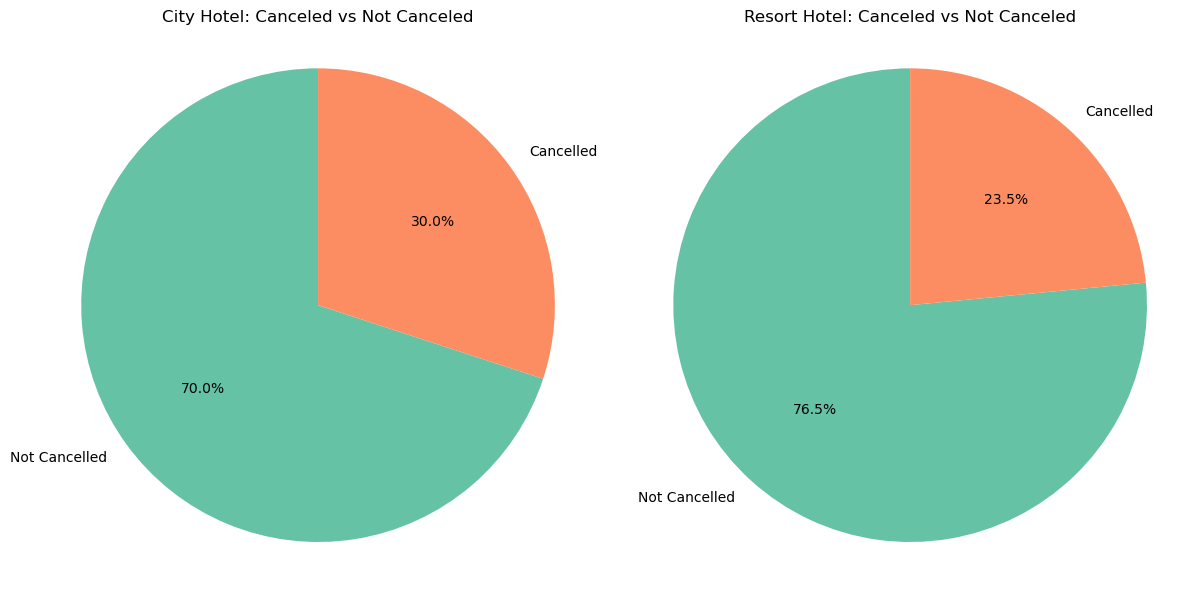

In [25]:
# Group by hotel and cancellation status
hotel_cancel_split = df.groupby(['hotel', 'is_canceled']).size().unstack().fillna(0)
hotel_cancel_split.columns = ['Not Cancelled', 'Cancelled']

# Normalize to get percentages
hotel_cancel_percent = hotel_cancel_split.div(hotel_cancel_split.sum(axis=1), axis=0) * 100

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# City Hotel pie chart
axs[0].pie(
    hotel_cancel_percent.loc['City Hotel'],
    labels=hotel_cancel_percent.columns,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66c2a5', '#fc8d62']
)
axs[0].set_title('City Hotel: Canceled vs Not Canceled')
axs[0].axis('equal')

# Resort Hotel pie chart
axs[1].pie(
    hotel_cancel_percent.loc['Resort Hotel'],
    labels=hotel_cancel_percent.columns,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66c2a5', '#fc8d62']
)
axs[1].set_title('Resort Hotel: Canceled vs Not Canceled')
axs[1].axis('equal')

plt.tight_layout()
plt.show()

The chart shows that City Hotels have a higher cancellation rate (30%) compared to Resort Hotels (23.5%). This suggests that guests booking City Hotels may be more likely to cancel their reservations, potentially due to more flexible plans, business travel uncertainties, or shorter booking lead times. Resort Hotel bookings, which are often for leisure or vacation, appear to be more committed.

## Market Segment vs Cancellation

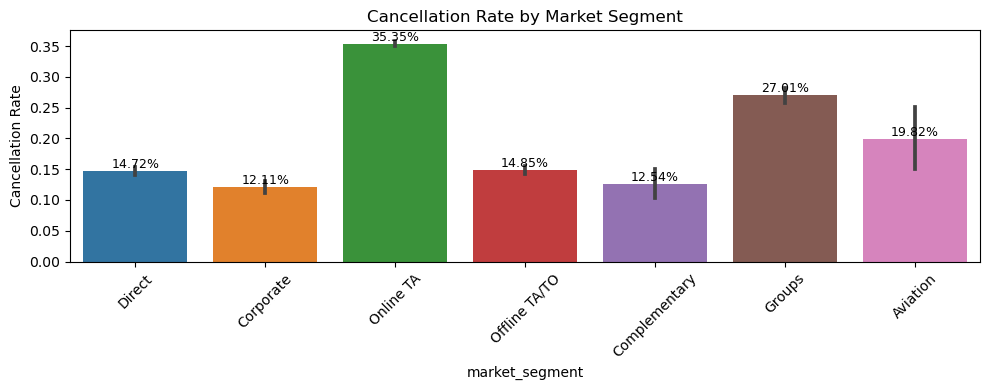

In [27]:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=df, x='market_segment', y='is_canceled', estimator=np.mean)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h.get_height()*100:.2f}%' for h in container], label_type='edge', fontsize=9)

plt.title('Cancellation Rate by Market Segment')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Online TA has the highest cancellation rate at 35.35%, followed by Groups at 27.01%, indicating these segments are more prone to cancellations. In contrast, Corporate, Direct, and Complementary segments show much lower cancellation rates (around 12–15%), suggesting more reliable bookings. Focusing on lower-risk segments or applying stricter policies to high-risk ones could reduce overall cancellations.

## Deposit Type vs Cancellation

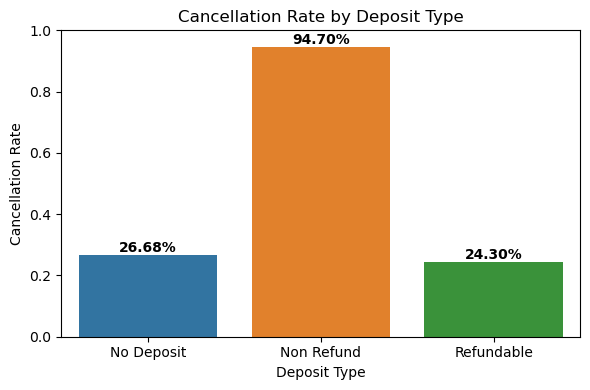

In [28]:
# Calculate mean cancellation rate by deposit type
cancel_by_deposit = df.groupby('deposit_type')['is_canceled'].mean().reset_index()

plt.figure(figsize=(6, 4))
barplot = sns.barplot(data=cancel_by_deposit, x='deposit_type', y='is_canceled')

# Add percentage labels on top of each bar
for index, row in cancel_by_deposit.iterrows():
    barplot.text(index, row['is_canceled'] + 0.01, f"{row['is_canceled']*100:.2f}%", 
                 color='black', ha="center", fontweight='bold')

plt.title('Cancellation Rate by Deposit Type')
plt.ylabel('Cancellation Rate')
plt.xlabel('Deposit Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Guests who selected 'Non Refund' as the deposit type have a significantly higher cancellation rate, nearing 95%, indicating that many of these bookings may be made speculatively despite being non-refundable. In contrast, 'No Deposit' and 'Refundable' bookings have a much lower cancellation rate, suggesting stronger booking intent.

## ADR Distribution By Cancellation

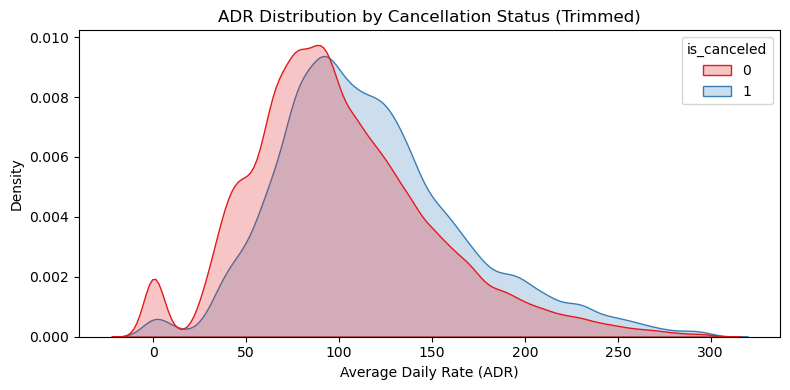

In [29]:
plt.figure(figsize=(8, 4))

# KDE plot with outliers removed (ADR capped at 300)
sns.kdeplot(
    data=df[(df['adr'].notna()) & np.isfinite(df['adr']) & (df['adr'] <= 300)], 
    x='adr', 
    hue='is_canceled', 
    fill=True, 
    common_norm=False, 
    palette='Set1'
)

plt.title("ADR Distribution by Cancellation Status (Trimmed)")
plt.xlabel("Average Daily Rate (ADR)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

The plot shows the distribution of Average Daily Rate (ADR) for both cancelled and non-cancelled bookings, excluding extreme outliers (ADR > 300). While the distributions overlap, cancelled bookings (blue) tend to have slightly higher ADRs on average compared to non-cancelled ones (red). This suggests guests paying higher rates may be more likely to cancel, potentially due to price sensitivity or booking flexibility. The concentration around the 50–150 range also indicates most bookings fall within a moderate price band.

## Lead Time Distribution

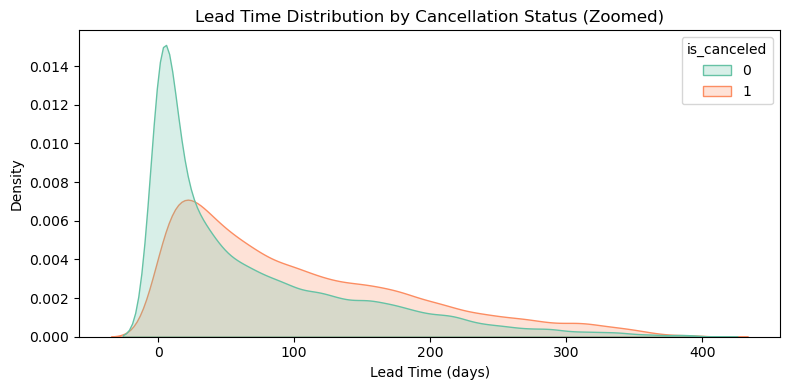

In [30]:
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df[df['lead_time'].notna() & np.isfinite(df['lead_time']) & (df['lead_time'] <= 400)],
    x='lead_time',
    hue='is_canceled',
    fill=True,
    common_norm=False,
    palette='Set2'
)
plt.title("Lead Time Distribution by Cancellation Status (Zoomed)")
plt.xlabel("Lead Time (days)")
plt.tight_layout()
plt.show()

- **Short Lead Times (< 20 days):**
Bookings that were not cancelled (is_canceled = 0) have a sharp peak at very short lead times, suggesting that last-minute bookings are more likely to be honored.

- **Longer Lead Times (> 50 days):**
The density of cancelled bookings (is_canceled = 1) is consistently higher as lead time increases. This implies that longer lead times are associated with a higher chance of cancellation.

- **Overall Trend:** Non-cancelled bookings tend to be made closer to the check-in date. Cancelled bookings tend to be made well in advance, possibly due to less commitment or change in plans over time.

## Total Nights vs Cancellation

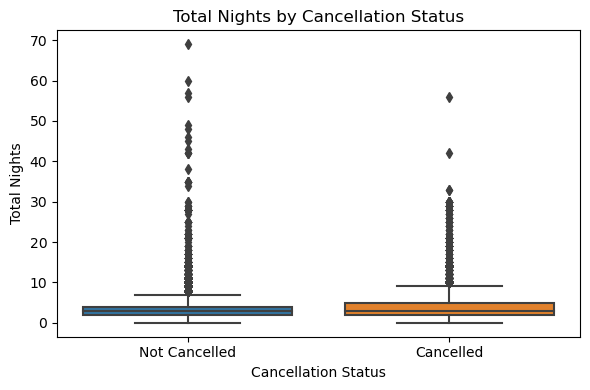

In [31]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df[df['total_nights'].notna()], x='is_canceled', y='total_nights')
plt.title('Total Nights by Cancellation Status')
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled'])
plt.xlabel('Cancellation Status')
plt.ylabel('Total Nights')
plt.tight_layout()
plt.show()

This boxplot shows that bookings with shorter stays (fewer total nights) are slightly more likely to be canceled compared to longer stays. Although the medians for both groups are close (around 3 nights), canceled bookings have a tighter distribution, suggesting they tend to be shorter. Outliers are present in both groups, but longer stays appear slightly more common in non-canceled bookings, which may indicate a higher commitment to longer reservations.

## Total Guests vs Cancellation

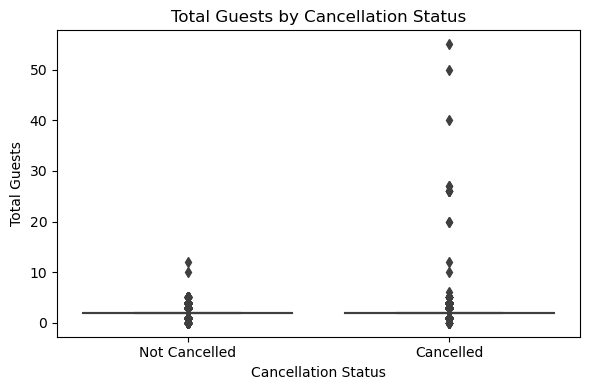

In [32]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df[df['total_guests'].notna()], x='is_canceled', y='total_guests')
plt.title('Total Guests by Cancellation Status')
plt.xlabel('Cancellation Status')
plt.ylabel('Total Guests')
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled'])
plt.tight_layout()
plt.show()

Most bookings, both cancelled and not, center around 1 to 3 guests. However, cancelled bookings display significantly more high-value outliers, with group sizes exceeding 20 or even 50 guests. This suggests that larger group bookings may carry a higher risk of cancellation, potentially due to greater coordination complexity or higher stakes involved.

## Feature Selection

C:\Users\dhars\AppData\Local\Temp\ipykernel_5296\2619697195.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


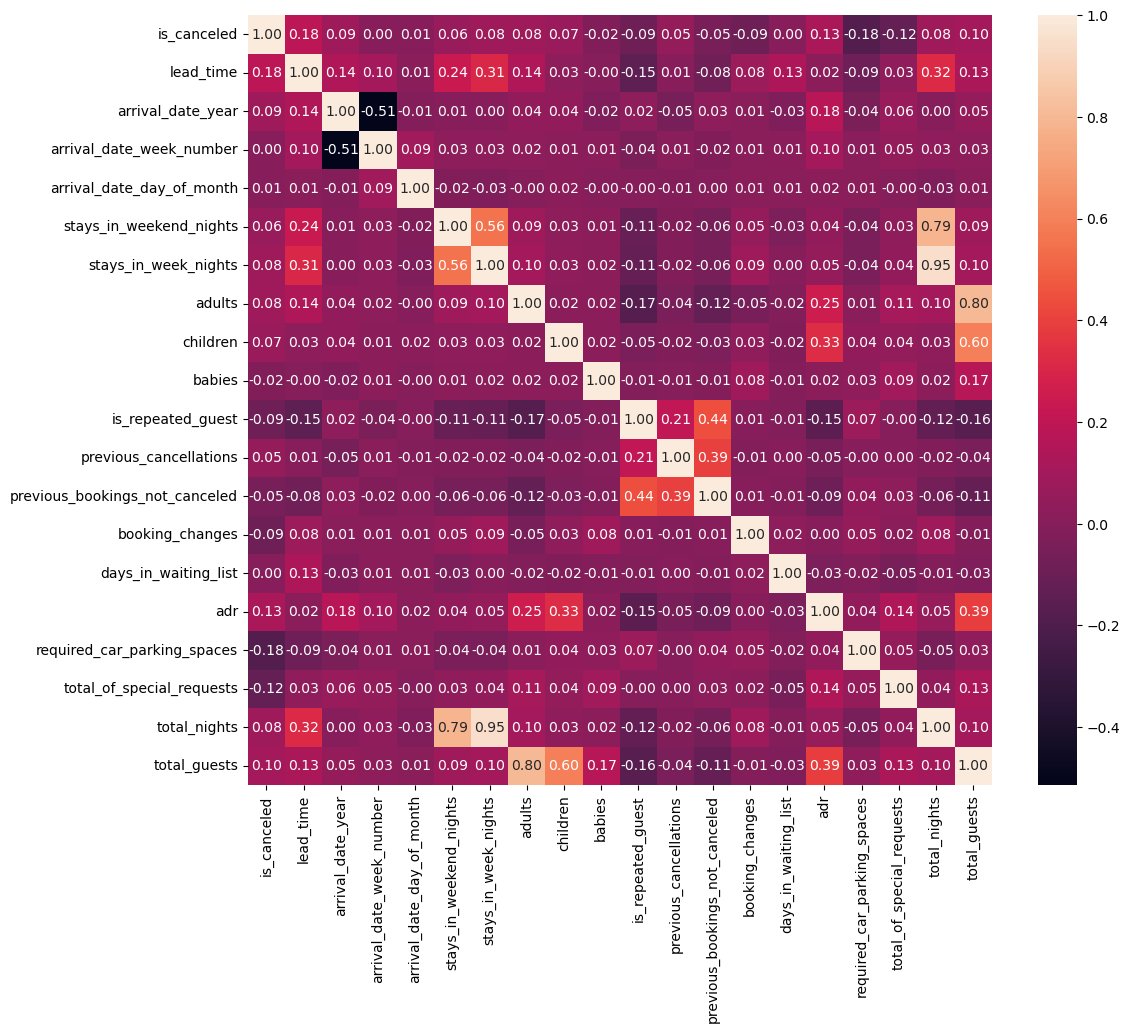

In [33]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

To prepare for classification modeling, a correlation heatmap was used to identify features most associated with booking cancellations. Key numerical features showing moderate correlation with is_canceled include lead_time, total_of_special_requests, previous_cancellations, and booking_changes. These features suggest patterns in customer behavior that may influence cancellations. Additionally, categorical variables such as market_segment, deposit_type, and customer_type showed clear differences in cancellation rates when visualized, indicating their predictive value. Therefore, a combination of selected numerical and encoded categorical features will be used for model training to ensure both behavioral and contextual factors are captured.